In [112]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import normalize

In [2]:
bit_strings = [f"{x:0{3}b}" for x in range(8)]

In [3]:
# the density matrix to swap test to discern unique values
dev2 = qml.device('default.qubit', wires=9)

@qml.qnode(dev2)
def cswap(arr):
    # input state
    coeff = np.sqrt(np.ones(len(arr[0]))/len(arr[0]))
    base = np.array(arr[0])
    qml.Superposition(coeff, base, wires=[1,2,3], work_wire=4)
    # ref state
    coeff = np.sqrt(np.ones(len(arr[1]))/len(arr[1]))
    base = np.array(arr[1])
    qml.Superposition(coeff, base, wires=[5,6,7], work_wire=8)
    
    qml.Hadamard(0)
    qml.CSWAP([0,1,5])
    qml.CSWAP([0,2,6])
    qml.CSWAP([0,3,7])
    
    qml.Hadamard(0)

    qml.Barrier(range(9))
    qml.measure(4)
    qml.measure(8)

    
    return qml.probs(0)

test_arr = [[[0,0,0],[0,0,1],[1,1,1]],[[0,0,0], [0,1,1],[1,0,1], [1,1,0], [1,1,1]]]
cswap(test_arr)

array([0.63333333, 0.36666667])

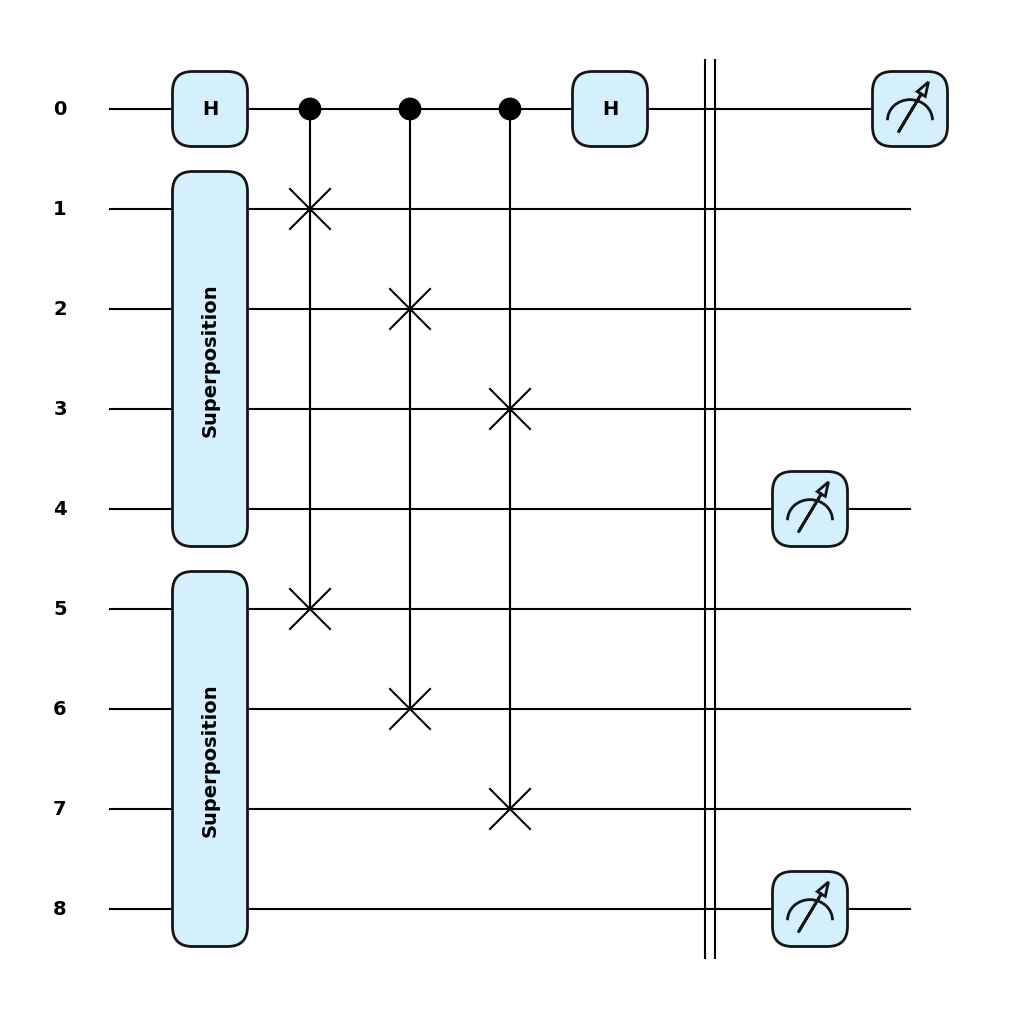

In [4]:
fig, _ = qml.draw_mpl(cswap, style="pennylane", show_all_wires=True)(test_arr)
plt.show()

In [29]:
# the density matrix to swap test to discern unique values
dev2 = qml.device('default.qubit', wires=9)

@qml.qnode(dev2)
def GroverSearch(arr, iter=1):
    # input state
    coeff = np.sqrt(np.ones(len(arr[0]))/len(arr[0]))
    base = np.array(arr[0])
    qml.Superposition(coeff, base, wires=[1,2,3], work_wire=4)
    # ref state
    coeff = np.sqrt(np.ones(len(arr[1]))/len(arr[1]))
    base = np.array(arr[1])
    qml.Superposition(coeff, base, wires=[5,6,7], work_wire=8)
    
    qml.Hadamard(0)
    qml.CSWAP([0,1,5])
    qml.CSWAP([0,2,6])
    qml.CSWAP([0,3,7])
    
    qml.Hadamard(0)
    p = qml.measure(0)

    qml.Barrier(range(9))
    qml.measure(4)
    qml.measure(8)
    
    for _ in range(iter): # amplify A
        qml.FlipSign([0,0,0], wires=[5,6,7])
        qml.FlipSign([0,0,1], wires=[5,6,7])
        qml.FlipSign([1,1,1], wires=[5,6,7])
        qml.templates.GroverOperator(wires=[5,6,7])

    return qml.probs(op=p), qml.probs([5,6,7])
    
GroverSearch(test_arr)

(array([0.66666667, 0.33333333]),
 array([0.13541667, 0.01041667, 0.09375   , 0.09375   , 0.09375   ,
        0.21875   , 0.21875   , 0.13541667]))

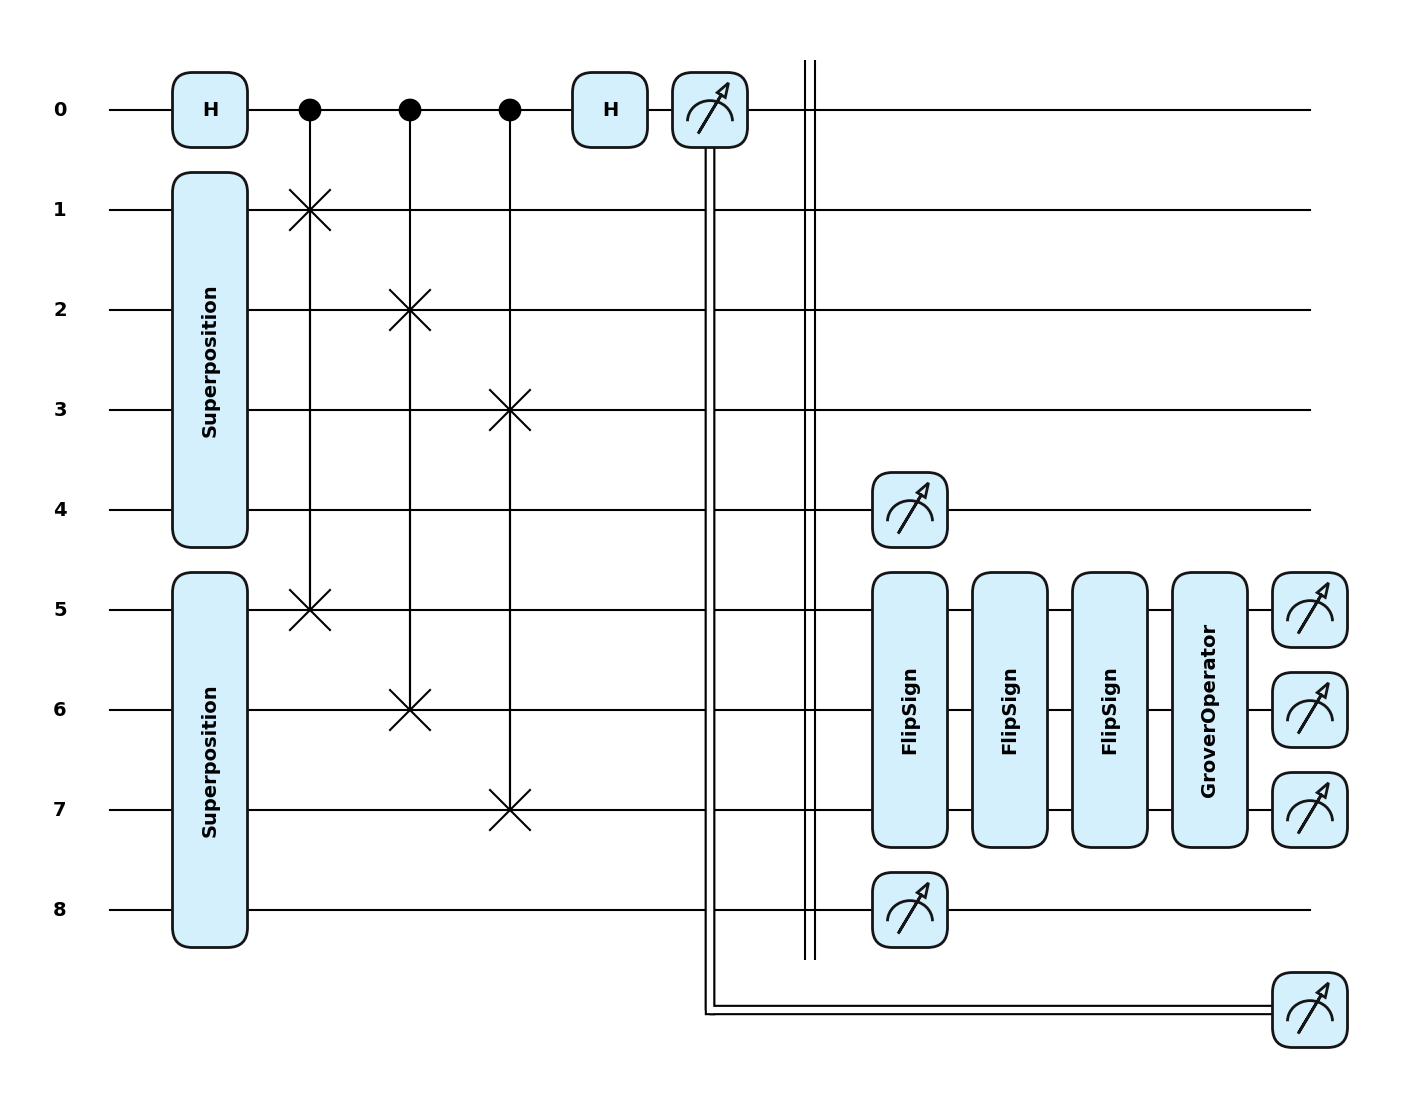

In [30]:
fig, _ = qml.draw_mpl(GroverSearch, style="pennylane", show_all_wires=True)(test_arr)
plt.show()

In [31]:
fig.savefig('swap_two_states.png')

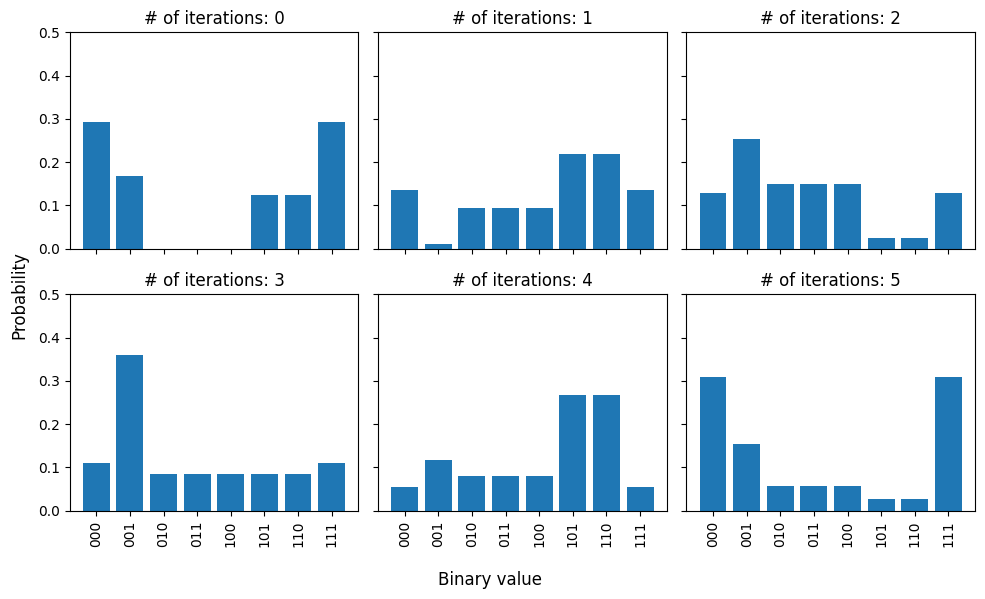

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

for i, ax in enumerate(axes.flat):  # Flatten the 2D array of axes
    probabilities = GroverSearch(test_arr, iter=i)[1]
    ax.bar(bit_strings, probabilities)
    # ax.set_xlabel("Binary value")
    # ax.set_ylabel("Probability")
    ax.set_xticks(range(len(bit_strings)))  # Set tick locations
    ax.set_xticklabels(bit_strings, rotation="vertical")  # Rotate labels
    ax.set_ylim([0,0.5])
    ax.set_title(f'# of iterations: {i}')
fig.supxlabel("Binary value")
fig.supylabel("Probability")
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [78]:
# the density matrix to swap test to discern unique values
dev2 = qml.device('default.qubit', wires=13)

@qml.qnode(dev2)
def GroverSearch(arr, iter1=1, iter2=1):
    # input state
    coeff = np.sqrt(np.ones(len(arr[0]))/len(arr[0]))
    base = np.array(arr[0])
    qml.Superposition(coeff, base, wires=[1,2,3], work_wire=4)
    # ref state
    coeff = np.sqrt(np.ones(len(arr[1]))/len(arr[1]))
    base = np.array(arr[1])
    qml.Superposition(coeff, base, wires=[5,6,7], work_wire=8)
    qml.Superposition(coeff, base, wires=[9,10,11], work_wire=12)
    
    qml.Hadamard(0)
    qml.CSWAP([0,1,5])
    qml.CSWAP([0,2,6])
    qml.CSWAP([0,3,7])
    
    qml.Hadamard(0)
    p = qml.measure(0)

    qml.measure(4)
    qml.measure(8)
    
    for _ in range(1): #5
        qml.FlipSign([0,0,0], wires=[5,6,7])
        qml.FlipSign([0,0,1], wires=[5,6,7])
        qml.FlipSign([1,1,1], wires=[5,6,7])
        qml.templates.GroverOperator(wires=[5,6,7])

    q1 = qml.measure(5)
    q2 = qml.measure(6)
    q3 = qml.measure(7)
    q = [q1, q2, q3]
    qml.Barrier(range(13))
        
    # Grover excluding the intersection
    for _ in range(iter1): #6
        qml.FlipSign([0,0,1], wires=[1,2,3])
        qml.templates.GroverOperator(wires=[1,2,3])
        
    for _ in range(iter2): #2
        qml.FlipSign([0,1,1], wires=[9,10,11])
        qml.FlipSign([1,0,1], wires=[9,10,11])
        qml.FlipSign([1,1,0], wires=[9,10,11])
        qml.templates.GroverOperator(wires=[9,10,11])    
    return qml.probs(op=p), qml.probs(op=q), qml.probs([1,2,3]), qml.probs([9,10,11])

GroverSearch(test_arr)

(array([0.63333333, 0.36666667]),
 array([0.16666667, 0.01666667, 0.1       , 0.15      , 0.1       ,
        0.15      , 0.15      , 0.16666667]),
 array([0.1       , 0.41666667, 0.16666667, 0.01666667, 0.16666667,
        0.01666667, 0.01666667, 0.1       ]),
 array([0.3125, 0.0125, 0.0125, 0.1125, 0.0125, 0.1125, 0.1125, 0.3125]))

Matplotlib is building the font cache; this may take a moment.


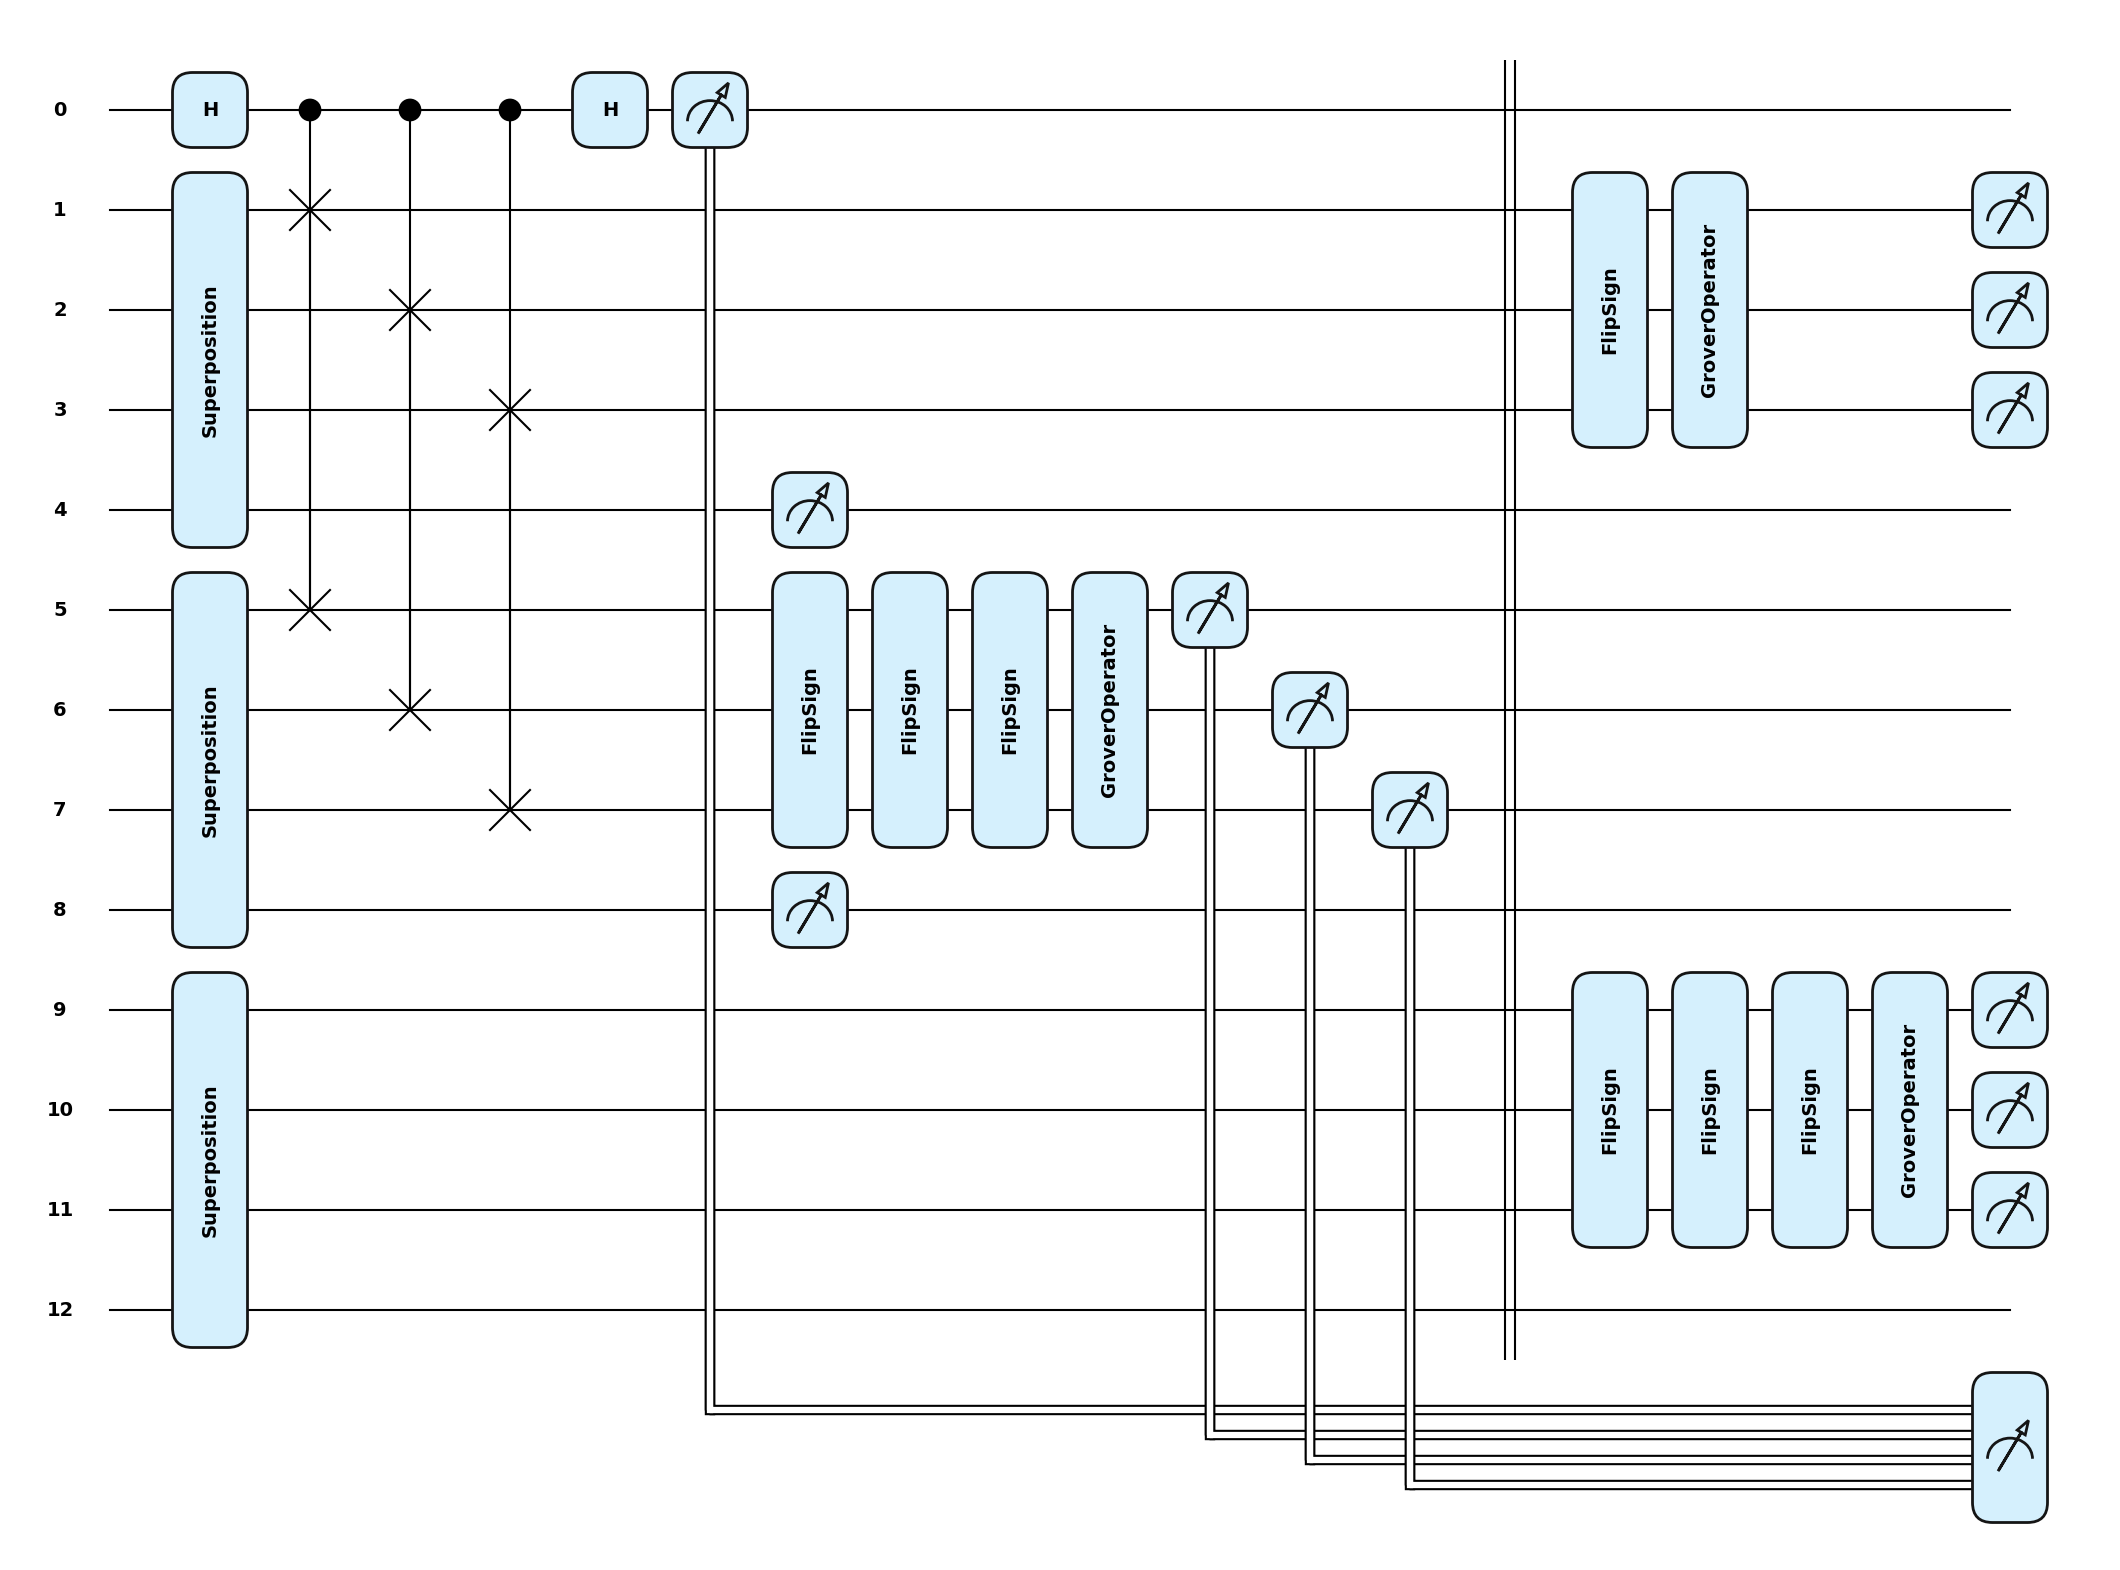

In [79]:
fig, _ = qml.draw_mpl(GroverSearch, style="pennylane", show_all_wires=True)(test_arr)
plt.show()

In [80]:
fig.savefig('set_operation_grover1.png')

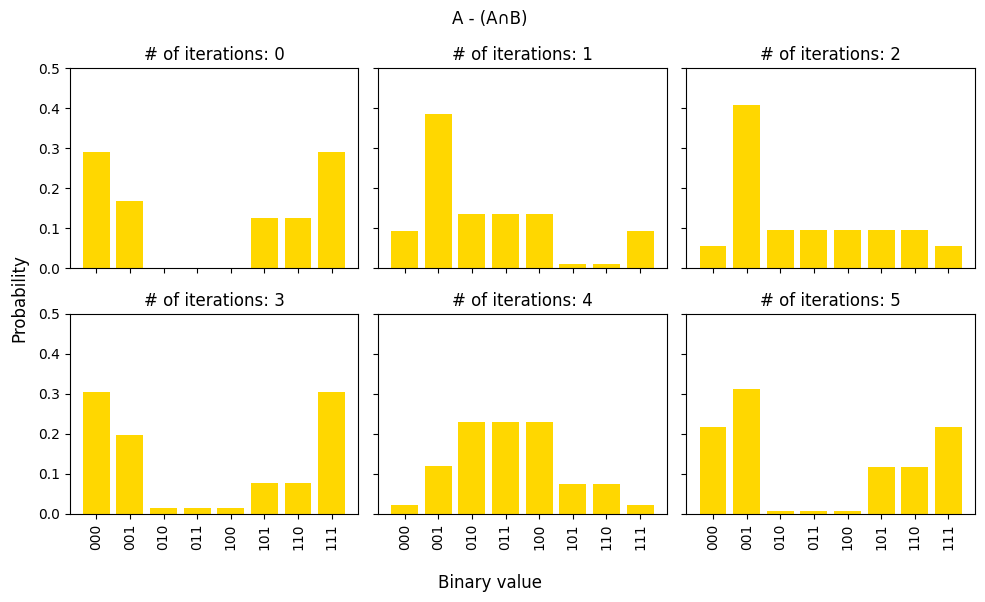

In [49]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

for i, ax in enumerate(axes.flat):  # Flatten the 2D array of axes
    probabilities = GroverSearch(test_arr, iter1=i)[2]
    ax.bar(bit_strings, probabilities, color='gold')
    # ax.set_xlabel("Binary value")
    # ax.set_ylabel("Probability")
    ax.set_xticks(range(len(bit_strings)))  # Set tick locations
    ax.set_xticklabels(bit_strings, rotation="vertical")  # Rotate labels
    ax.set_ylim([0,0.5])
    ax.set_title(f'# of iterations: {i}')
fig.suptitle("A - (A∩B)")
fig.supxlabel("Binary value")
fig.supylabel("Probability")
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

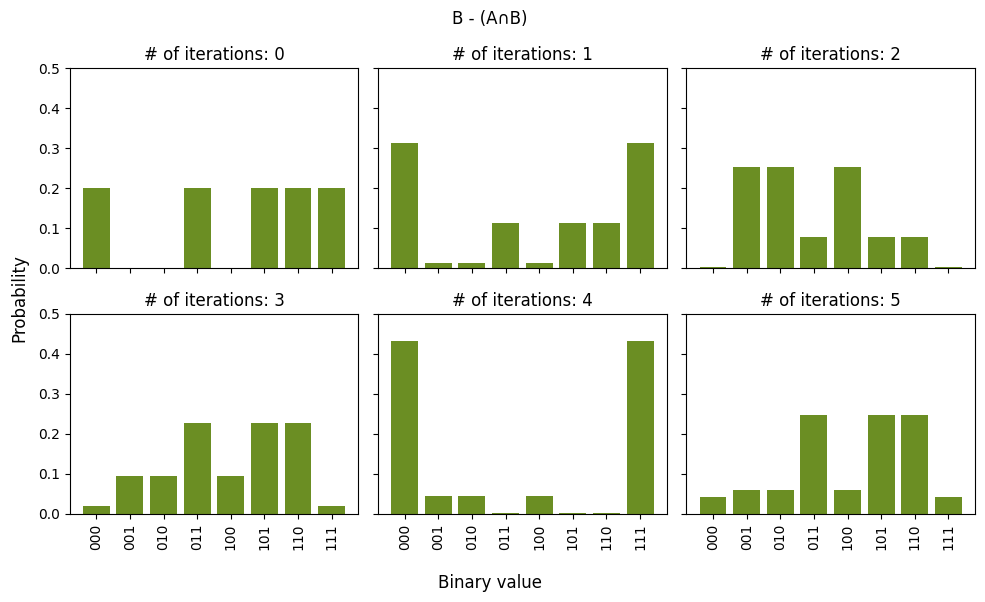

In [81]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

for i, ax in enumerate(axes.flat):  # Flatten the 2D array of axes
    probabilities = GroverSearch(test_arr, iter2=i)[3]
    ax.bar(bit_strings, probabilities, color='olivedrab')
    ax.set_xticks(range(len(bit_strings)))  # Set tick locations
    ax.set_xticklabels(bit_strings, rotation="vertical")  # Rotate labels
    ax.set_ylim([0,0.5])
    ax.set_title(f'# of iterations: {i}')
fig.suptitle("B - (A∩B)")
fig.supxlabel("Binary value")
fig.supylabel("Probability")
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

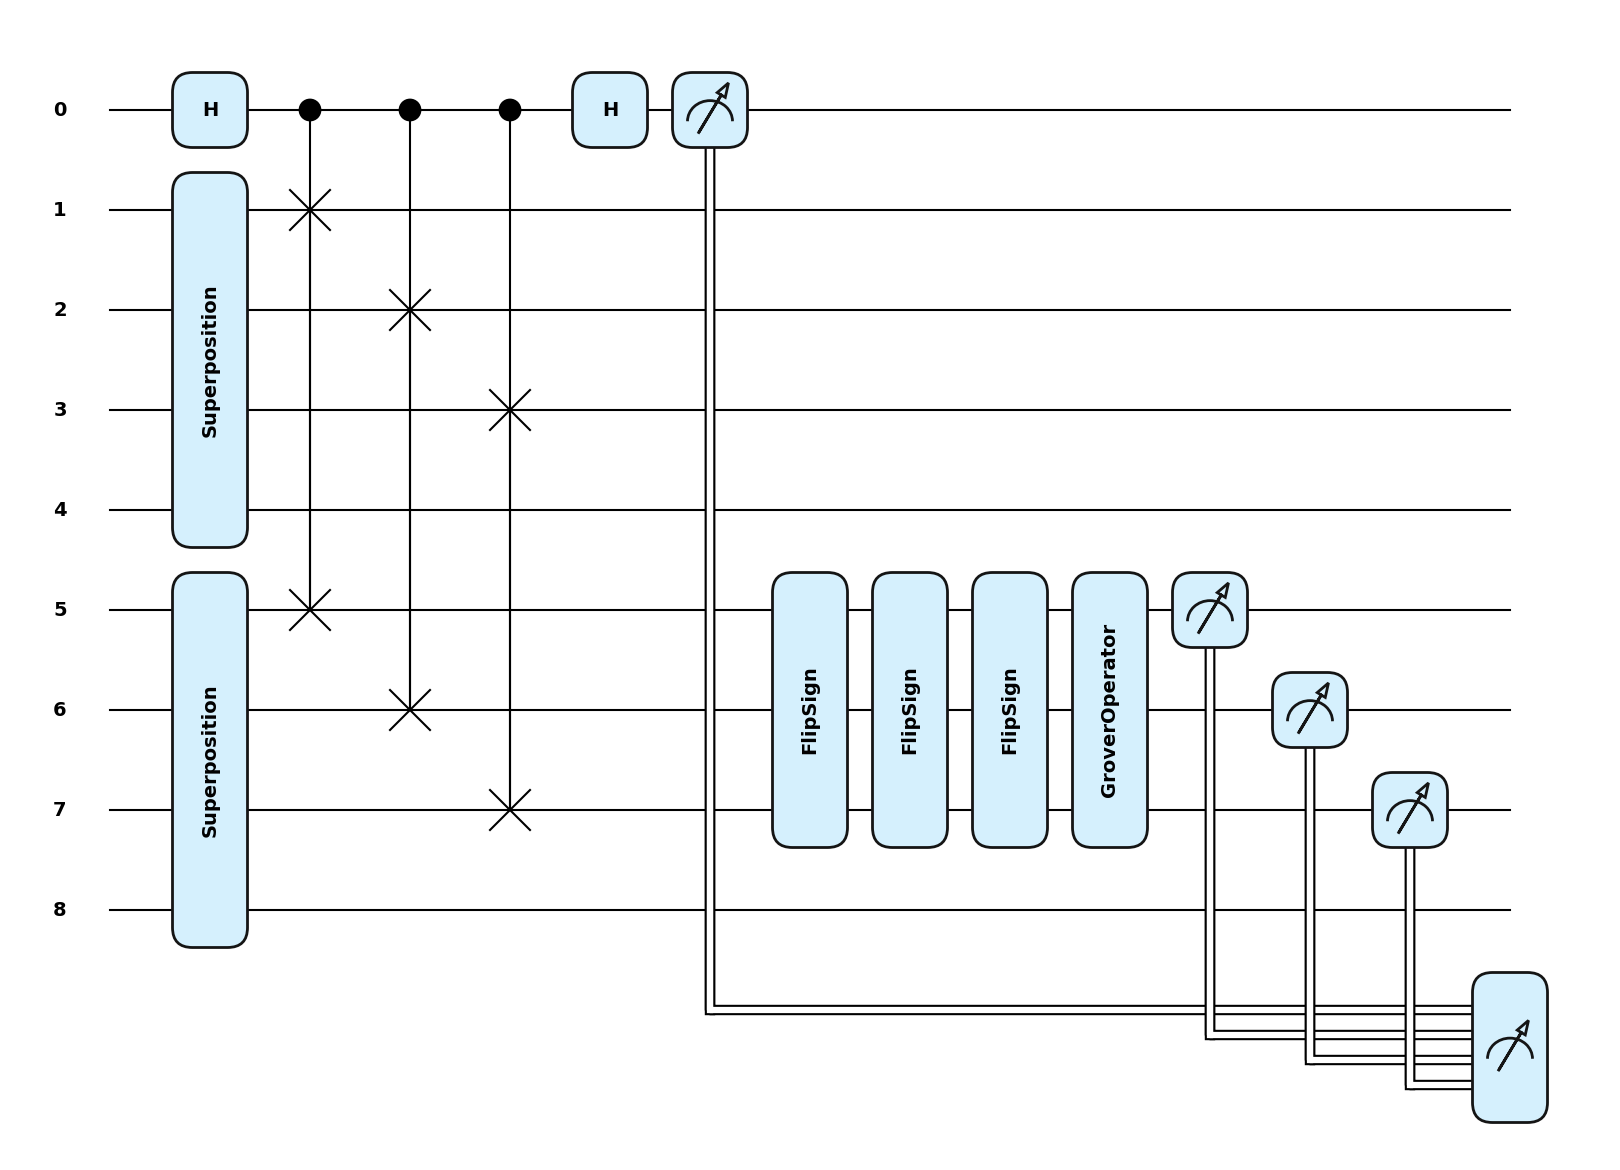

In [101]:
# the density matrix to swap test to discern unique values
dev2 = qml.device('default.qubit', wires=9)

@qml.qnode(dev2)
def GroverSearch(arr, iter1=1, iter2=1, iter3=1):
    # input state
    coeff = np.sqrt(np.ones(len(arr[0]))/len(arr[0]))
    base = np.array(arr[0])
    qml.Superposition(coeff, base, wires=[1,2,3], work_wire=4)
    # ref state
    coeff = np.sqrt(np.ones(len(arr[1]))/len(arr[1]))
    base = np.array(arr[1])
    qml.Superposition(coeff, base, wires=[5,6,7], work_wire=8)
    # qml.Superposition(coeff, base, wires=[9,10,11], work_wire=12)
    
    qml.Hadamard(0)
    qml.CSWAP([0,1,5])
    qml.CSWAP([0,2,6])
    qml.CSWAP([0,3,7])
    
    qml.Hadamard(0)
    p = qml.measure(0)
    # qml.Barrier(range(17))
    
    for _ in range(1): #5
        qml.FlipSign([0,0,0], wires=[5,6,7])
        qml.FlipSign([0,0,1], wires=[5,6,7])
        qml.FlipSign([1,1,1], wires=[5,6,7])
        qml.templates.GroverOperator(wires=[5,6,7])
    
    q1 = qml.measure(5)
    q2 = qml.measure(6)
    q3 = qml.measure(7)
    q = [q1, q2, q3]
    # qml.Barrier(range(17))

    # qml.Superposition(coeff, base, wires=[9,10,11], work_wire=12)
    
    # # Grover excluding the intersection
    # for _ in range(iter1): #1
    #     qml.FlipSign([0,0,1], wires=[1,2,3])
    #     qml.templates.GroverOperator(wires=[1,2,3])
        
    # for _ in range(iter2): #3
    #     qml.FlipSign([0,1,1], wires=[9,10,11])
    #     qml.FlipSign([1,0,1], wires=[9,10,11])
    #     qml.FlipSign([1,1,0], wires=[9,10,11])
    #     qml.templates.GroverOperator(wires=[9,10,11])    

    # qml.measure(1)
    # qml.measure(2)
    # qml.measure(3)

    # qml.measure(9)
    # qml.measure(10)
    # qml.measure(11)
    
    # qml.Barrier(range(17))
    # tot = [[0,0,0],[0,0,1],[0,1,0],[1,0,0],[1,1,0],[1,0,1],[0,1,1],[1,1,1]]
    # coeff = np.sqrt(np.ones(len(tot))/len(tot))
    # base = np.array(tot)
    # qml.Superposition(coeff, base, wires=[13,14,15], work_wire=16)

    # for _ in range(iter3):
    #     qml.FlipSign([1,0,0], wires=[13,14,15])
    #     qml.FlipSign([0,1,0], wires=[13,14,15])
    #     qml.templates.GroverOperator(wires=[13,14,15]) 

    return qml.probs(op=p), qml.probs(op=q)
    
fig, _ = qml.draw_mpl(GroverSearch, style="pennylane", show_all_wires=True)(test_arr)
plt.show()

In [102]:
fig.savefig('grover4_intersection.png')

In [96]:
# the density matrix to swap test to discern unique values
dev2 = qml.device('default.qubit', wires=17)

@qml.qnode(dev2)
def GroverSearch(arr, iter1=1, iter2=1, iter3=1):
    # input state
    coeff = np.sqrt(np.ones(len(arr[0]))/len(arr[0]))
    base = np.array(arr[0])
    qml.Superposition(coeff, base, wires=[1,2,3], work_wire=4)
    # ref state
    coeff = np.sqrt(np.ones(len(arr[1]))/len(arr[1]))
    base = np.array(arr[1])
    qml.Superposition(coeff, base, wires=[5,6,7], work_wire=8)
    # qml.Superposition(coeff, base, wires=[9,10,11], work_wire=12)
    
    qml.Hadamard(0)
    qml.CSWAP([0,1,5])
    qml.CSWAP([0,2,6])
    qml.CSWAP([0,3,7])
    
    qml.Hadamard(0)
    p = qml.measure(0)
    # qml.Barrier(range(17))
    
    for _ in range(1): #5
        qml.FlipSign([0,0,0], wires=[5,6,7])
        qml.FlipSign([0,0,1], wires=[5,6,7])
        qml.FlipSign([1,1,1], wires=[5,6,7])
        qml.templates.GroverOperator(wires=[5,6,7])
    
    q1 = qml.measure(5)
    q2 = qml.measure(6)
    q3 = qml.measure(7)
    q = [q1, q2, q3]
    qml.Barrier(range(17))

    qml.Superposition(coeff, base, wires=[9,10,11], work_wire=12)
    
    # Grover excluding the intersection
    for _ in range(iter1): #1
        qml.FlipSign([0,0,1], wires=[1,2,3])
        qml.templates.GroverOperator(wires=[1,2,3])
        
    for _ in range(iter2): #3
        qml.FlipSign([0,1,1], wires=[9,10,11])
        qml.FlipSign([1,0,1], wires=[9,10,11])
        qml.FlipSign([1,1,0], wires=[9,10,11])
        qml.templates.GroverOperator(wires=[9,10,11])    

    qml.measure(1)
    qml.measure(2)
    qml.measure(3)

    qml.measure(9)
    qml.measure(10)
    qml.measure(11)
    
    qml.Barrier(range(17))
    tot = [[0,0,0],[0,0,1],[0,1,0],[1,0,0],[1,1,0],[1,0,1],[0,1,1],[1,1,1]]
    coeff = np.sqrt(np.ones(len(tot))/len(tot))
    base = np.array(tot)
    qml.Superposition(coeff, base, wires=[13,14,15], work_wire=16)

    for _ in range(iter3):
        qml.FlipSign([1,0,0], wires=[13,14,15])
        qml.FlipSign([0,1,0], wires=[13,14,15])
        qml.templates.GroverOperator(wires=[13,14,15]) 

    return qml.probs(op=p), qml.probs(op=q), qml.probs([13,14,15])

GroverSearch(test_arr)

(array([0.63333333, 0.36666667]),
 array([0.16666667, 0.01666667, 0.1       , 0.15      , 0.1       ,
        0.15      , 0.15      , 0.16666667]),
 array([1.32207277e-32, 3.34765657e-33, 5.00000000e-01, 9.83690407e-34,
        5.00000000e-01, 1.19267273e-33, 9.73913233e-34, 6.71648746e-33]))

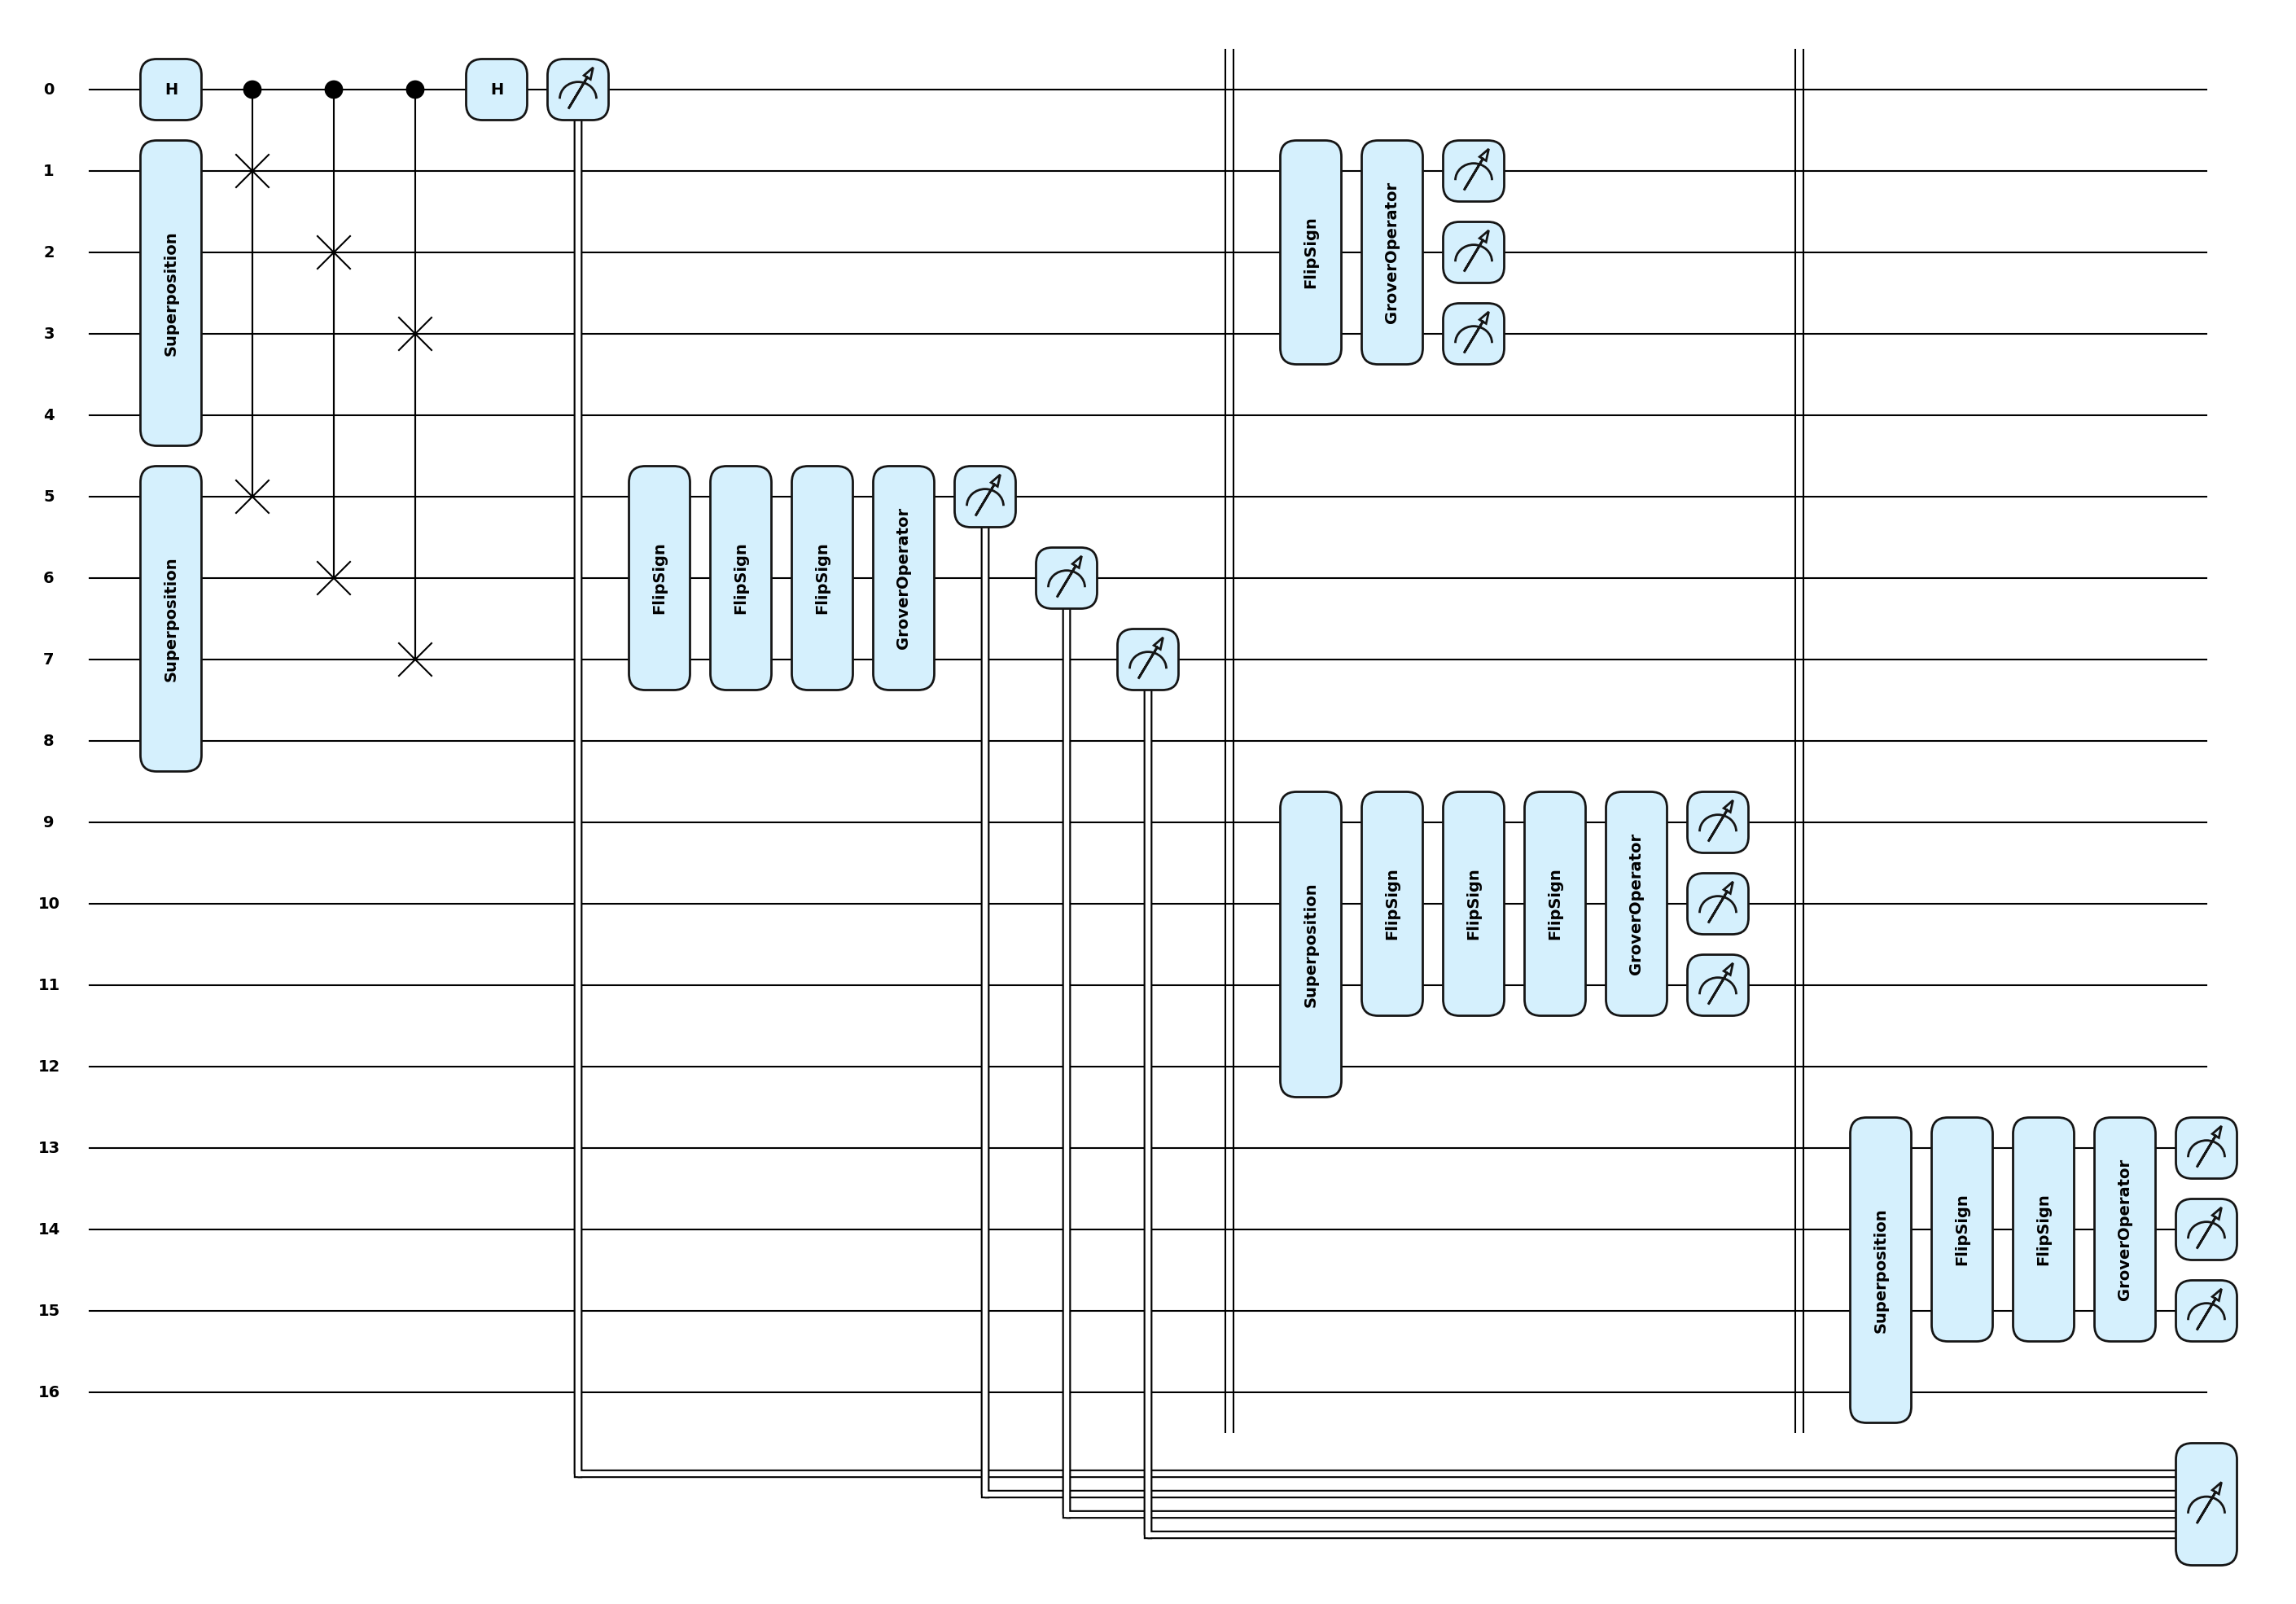

In [97]:
fig, _ = qml.draw_mpl(GroverSearch, style="pennylane", show_all_wires=True)(test_arr)
plt.show()

In [98]:
fig.savefig('grover4_measurements.png')

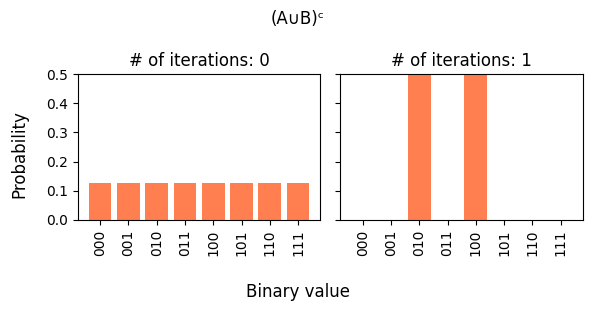

In [121]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)

for i, ax in enumerate(axes.flat):  # Flatten the 2D array of axes
    probabilities = GroverSearch(test_arr, iter3=i)[2]
    ax.bar(bit_strings, probabilities, color='coral')
    ax.set_xticks(range(len(bit_strings)))  # Set tick locations
    ax.set_xticklabels(bit_strings, rotation="vertical")  # Rotate labels
    ax.set_ylim([0,0.5])
    ax.set_title(f'# of iterations: {i}')
fig.suptitle("(A∪B)ᶜ")
fig.supxlabel("Binary value")
fig.supylabel("Probability")
plt.tight_layout() 
plt.show()

In [122]:
fig.savefig('grover_final.png')

In [78]:
# the density matrix to swap test to discern unique values
dev2 = qml.device('default.qubit', wires=17)

@qml.qnode(dev2)
def GroverSearch(arr, iter1=1, iter2=1, iter3=1):
    ########################################################################### to find elements in the intersection
    # input state
    coeff = np.sqrt(np.ones(len(arr[0]))/len(arr[0]))
    base = np.array(arr[0])
    qml.Superposition(coeff, base, wires=[1,2,3], work_wire=4)
    # ref state
    coeff = np.sqrt(np.ones(len(arr[1]))/len(arr[1]))
    base = np.array(arr[1])
    qml.Superposition(coeff, base, wires=[5,6,7], work_wire=8)
    # qml.Superposition(coeff, base, wires=[9,10,11], work_wire=12)
    
    qml.Hadamard(0)
    qml.CSWAP([0,1,5])
    qml.CSWAP([0,2,6])
    qml.CSWAP([0,3,7])
    
    qml.Hadamard(0)
    p = qml.measure(0)
    qml.Barrier(range(17))
    
    for _ in range(1): #5
        qml.FlipSign([0,0,0], wires=[5,6,7])
        qml.FlipSign([0,0,1], wires=[5,6,7])
        qml.FlipSign([1,1,1], wires=[5,6,7])
        qml.templates.GroverOperator(wires=[5,6,7])
    
    q1 = qml.measure(5,reset=True)
    q2 = qml.measure(6,reset=True)
    q3 = qml.measure(7,reset=True)
    # q = [q1, q2, q3]
    qml.Barrier(range(17))
    ###########################################################################
    
    # Unitary gate to sift the remaining element
    # for _ in range(iter1): #1
    #     qml.FlipSign([0,0,1], wires=[1,2,3])
    #     qml.templates.GroverOperator(wires=[1,2,3])
    
    U = np.diag([0,1,0,0,0,0,0,0])
    qml.QubitUnitary(U, wires=[1,2,3])    

    #B
    qml.Superposition(coeff, base, wires=[9,10,11], work_wire=12)
    # for _ in range(iter2): #3
    #     qml.FlipSign([0,1,1], wires=[9,10,11])
    #     qml.FlipSign([1,0,1], wires=[9,10,11])
    #     qml.FlipSign([1,1,0], wires=[9,10,11])
    #     qml.templates.GroverOperator(wires=[9,10,11])  
    
    U = np.diag([0,0,0,1,0,1,1,0]/np.sqrt(3))
    qml.QubitUnitary(U, wires=[9,10,11])  

    # AB
    inter = [[0,0,0],[1,1,1]]
    coeff = np.sqrt(np.ones(len(inter))/len(inter))
    base = np.array(inter)
    qml.Superposition(coeff, base, wires=[5,6,7], work_wire=8)
    
    # qml.Barrier(range(17))
    tot = [[0,0,0],[0,0,1],[0,1,0],[1,0,0],[1,1,0],[1,0,1],[0,1,1],[1,1,1]]
    coeff = np.sqrt(np.ones(len(tot))/len(tot))
    base = np.array(tot)
    qml.Superposition(coeff, base, wires=[13,14,15], work_wire=16)

    U = np.diag([0,0,1,0,1,0,0,0]/np.sqrt(2))
    qml.QubitUnitary(U, wires=[13,14,15])  

    # return qml.probs(op=p), qml.probs(op=q), qml.probs([1,2,3]), qml.probs([9,10,11]), qml.probs([13,14,15])
    return qml.probs([1,2,3]), qml.probs([5,6,7]), qml.probs([9,10,11]), qml.probs([13,14,15]) 

GroverSearch(test_arr)

(array([0.        , 0.00416667, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]),
 array([2.08333333e-03, 4.62227474e-38, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.62227474e-38, 2.08333333e-03]),
 array([0.        , 0.        , 0.        , 0.00138889, 0.        ,
        0.00138889, 0.00138889, 0.        ]),
 array([0.        , 0.        , 0.00208333, 0.        , 0.00208333,
        0.        , 0.        , 0.        ]))

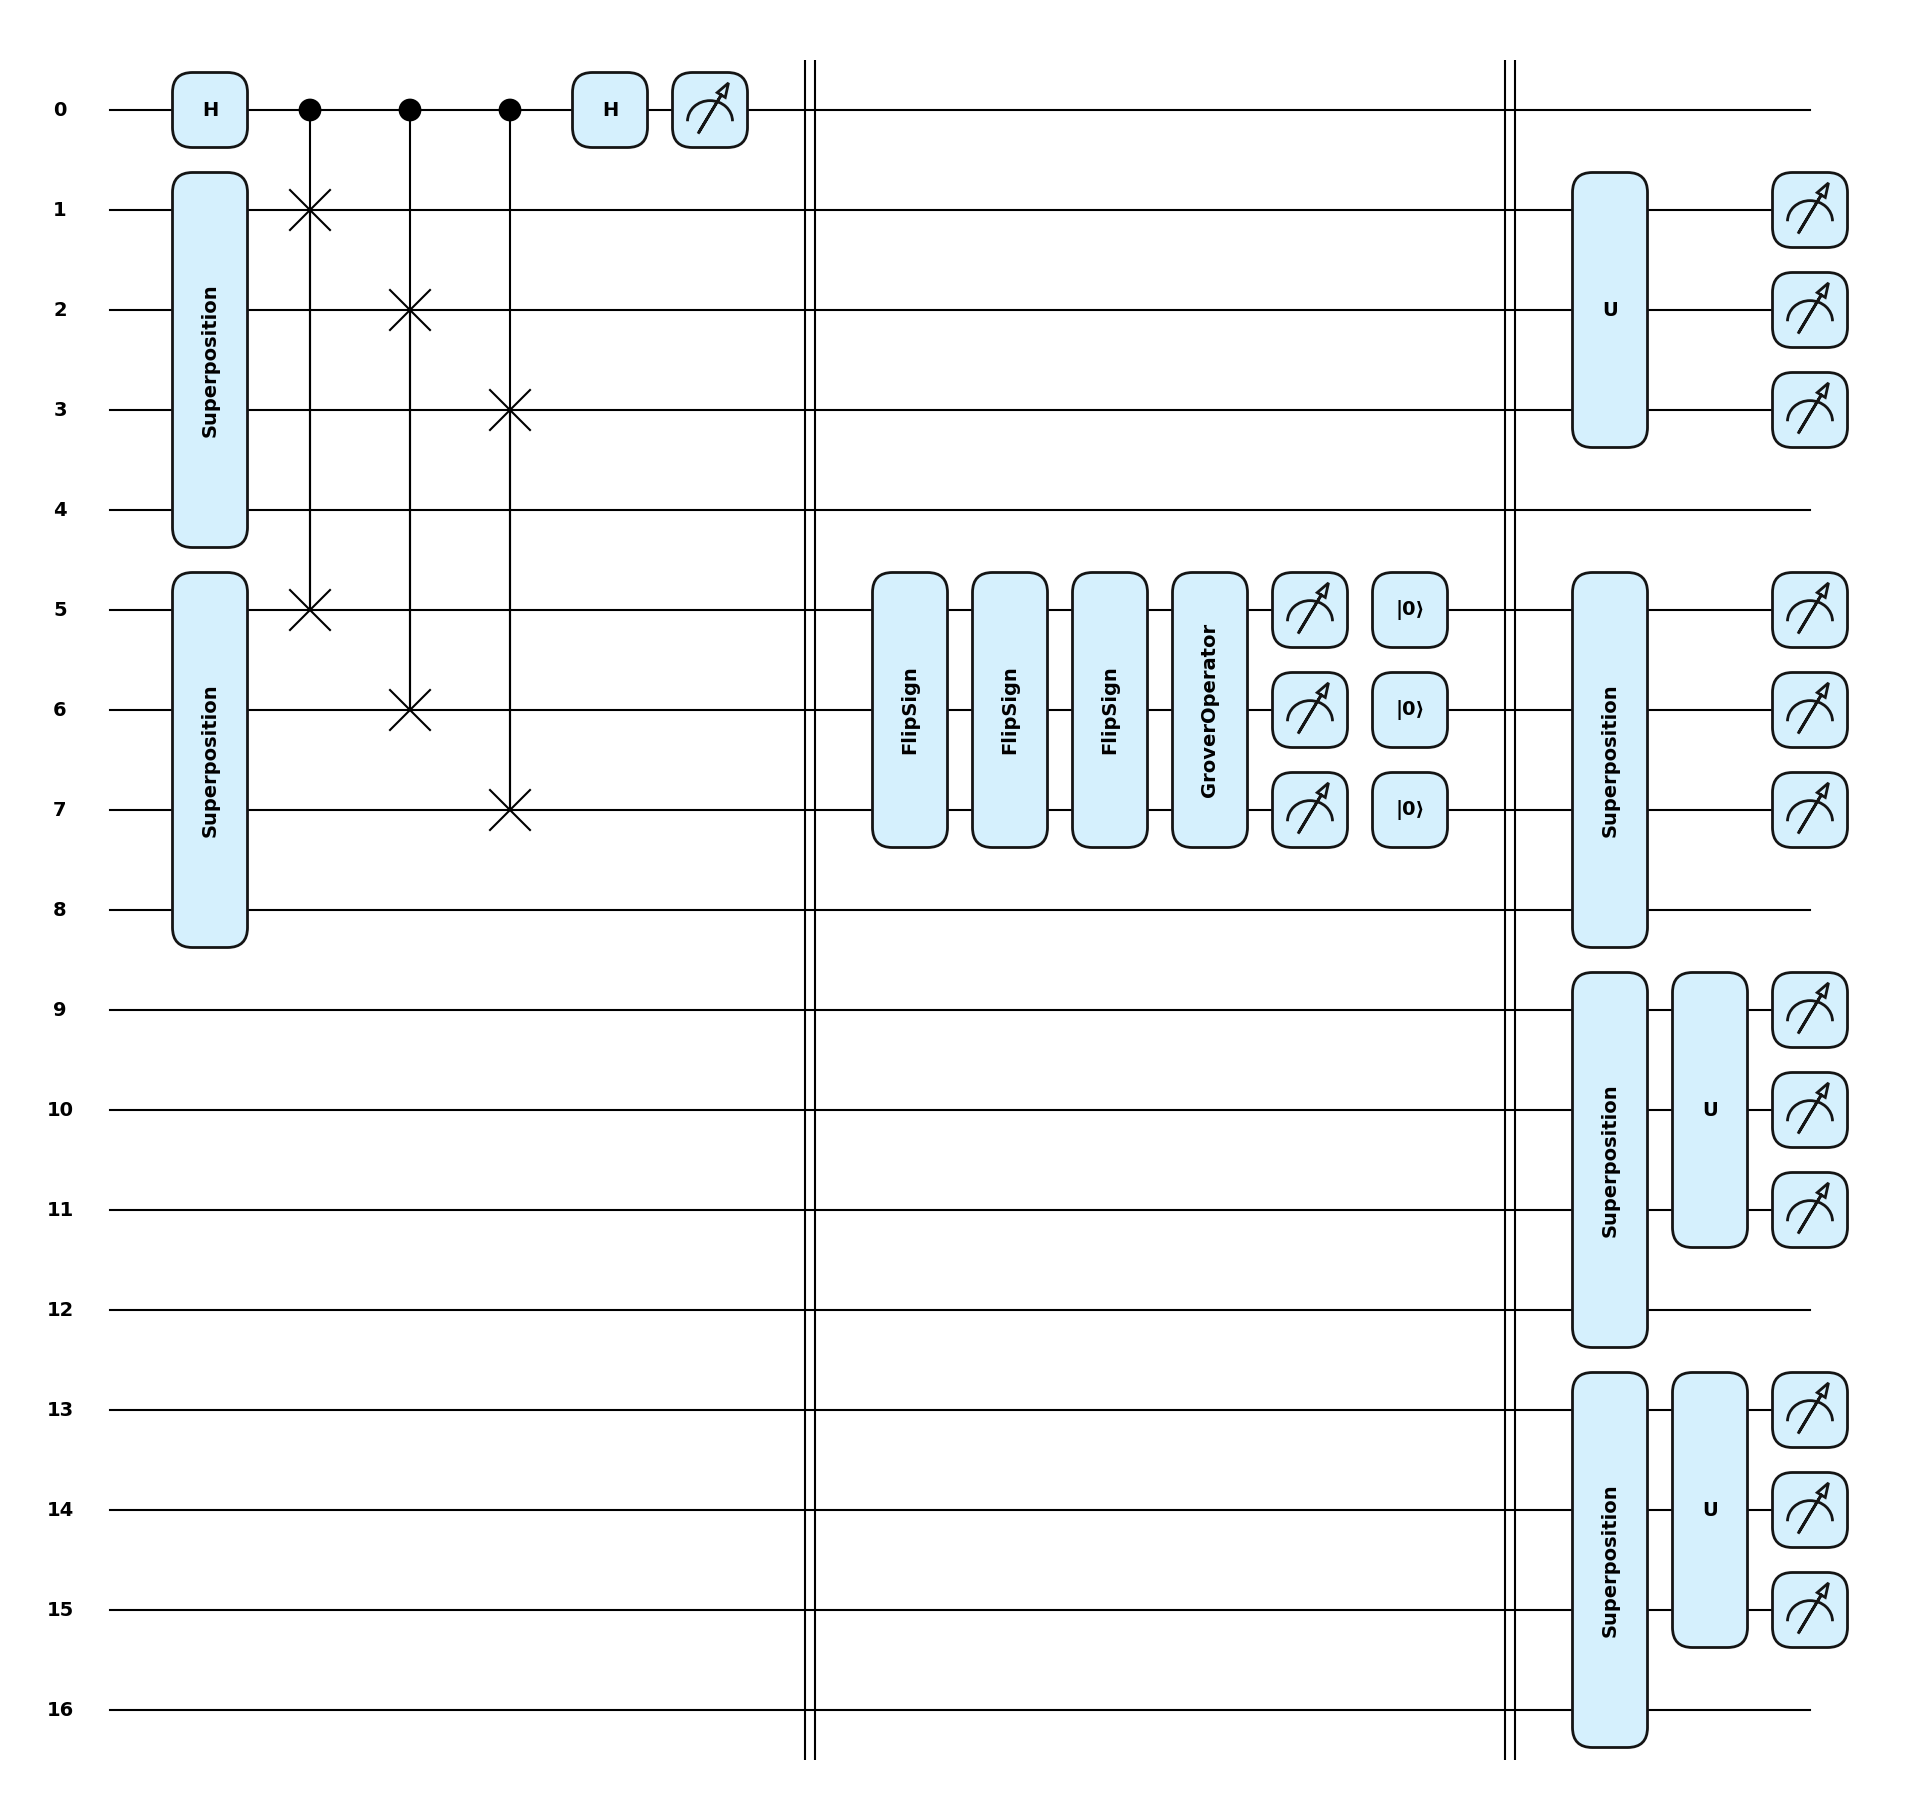

In [79]:
fig, _ = qml.draw_mpl(GroverSearch, style="pennylane", show_all_wires=True)(test_arr)
plt.show()

In [54]:
fig.savefig('set_unitary.png')

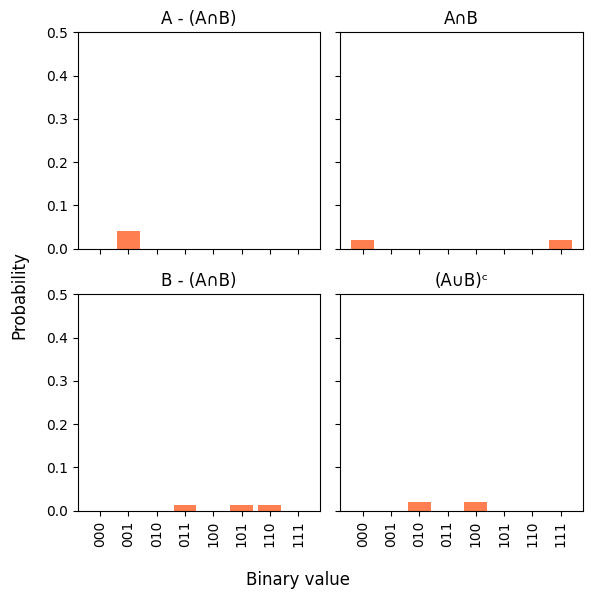

In [84]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=True)
title = ["A - (A∩B)", "A∩B", "B - (A∩B)", "(A∪B)ᶜ"]
for i, ax in enumerate(axes.flat):  # Flatten the 2D array of axes
    probabilities = GroverSearch(test_arr)[i]
    ax.bar(bit_strings, probabilities*10, color='coral')
    ax.set_xticks(range(len(bit_strings)))  # Set tick locations 4
    ax.set_xticklabels(bit_strings, rotation="vertical")  # Rotate labels
    ax.set_ylim([0,0.5])
    ax.set_title(title[i])
fig.supxlabel("Binary value")
fig.supylabel("Probability")
plt.tight_layout() 
plt.show()

In [85]:
fig.savefig('unitary_results.png')

In [43]:
# the density matrix to swap test to discern unique values
dev2 = qml.device('default.qubit', wires=19)

@qml.qnode(dev2)
def circuit(arr):
    # A
    coeff = np.sqrt(np.ones(len(arr[0]))/len(arr[0]))
    base = np.array(arr[0])
    qml.Superposition(coeff, base, wires=[1,2,3], work_wire=4)
    # qml.measure(4)

    # AB
    inter = [[0,0,0],[1,1,1]]
    coeff = np.sqrt(np.ones(len(inter))/len(inter))
    base = np.array(inter)
    qml.Superposition(coeff, base, wires=[5,6,7], work_wire=8)
    # qml.measure(8)

    # CNOT
    qml.CNOT([1,9])
    qml.CNOT([2,10])
    qml.CNOT([3,11])
    qml.CNOT([5,9])
    qml.CNOT([6,10])
    qml.CNOT([7,11])
    qml.CNOT([9,12])
    qml.CNOT([10,12])
    qml.CNOT([10,13])
    qml.CNOT([11,13])

    qml.PauliX(12)
    qml.PauliX(13)
    
    qml.Toffoli([12,13,14])

    # trace out
    qml.measure(14,reset=True,postselect=0)
    qml.Barrier(range(19))
    qml.measure(9,reset=True)
    qml.measure(10,reset=True)
    qml.measure(11,reset=True)
    qml.measure(12,reset=True)
    qml.measure(13,reset=True)
    
    # B - later
    coeff = np.sqrt(np.ones(len(arr[1]))/len(arr[1]))
    base = np.array(arr[1])
    qml.Superposition(coeff, base, wires=[15,16,17], work_wire=18)

    # CNOT
    qml.CNOT([15,9])
    qml.CNOT([16,10])
    qml.CNOT([17,11])
    qml.CNOT([5,9])
    qml.CNOT([6,10])
    qml.CNOT([7,11])
    qml.CNOT([9,12])
    qml.CNOT([10,12])
    qml.CNOT([10,13])
    qml.CNOT([11,13])

    qml.PauliX(12)
    qml.PauliX(13)
    
    qml.Toffoli([12,13,14])

    # trace out
    qml.measure(14,postselect=0)
    qml.Barrier(range(19))
    
    return qml.probs([1,2,3]), qml.probs([5,6,7]), qml.probs([15,16,17])
    
test_arr = [[[0,0,0],[0,0,1],[1,1,1]],[[0,0,0], [0,1,1],[1,0,1], [1,1,0], [1,1,1]]]
# circuit(test_arr)

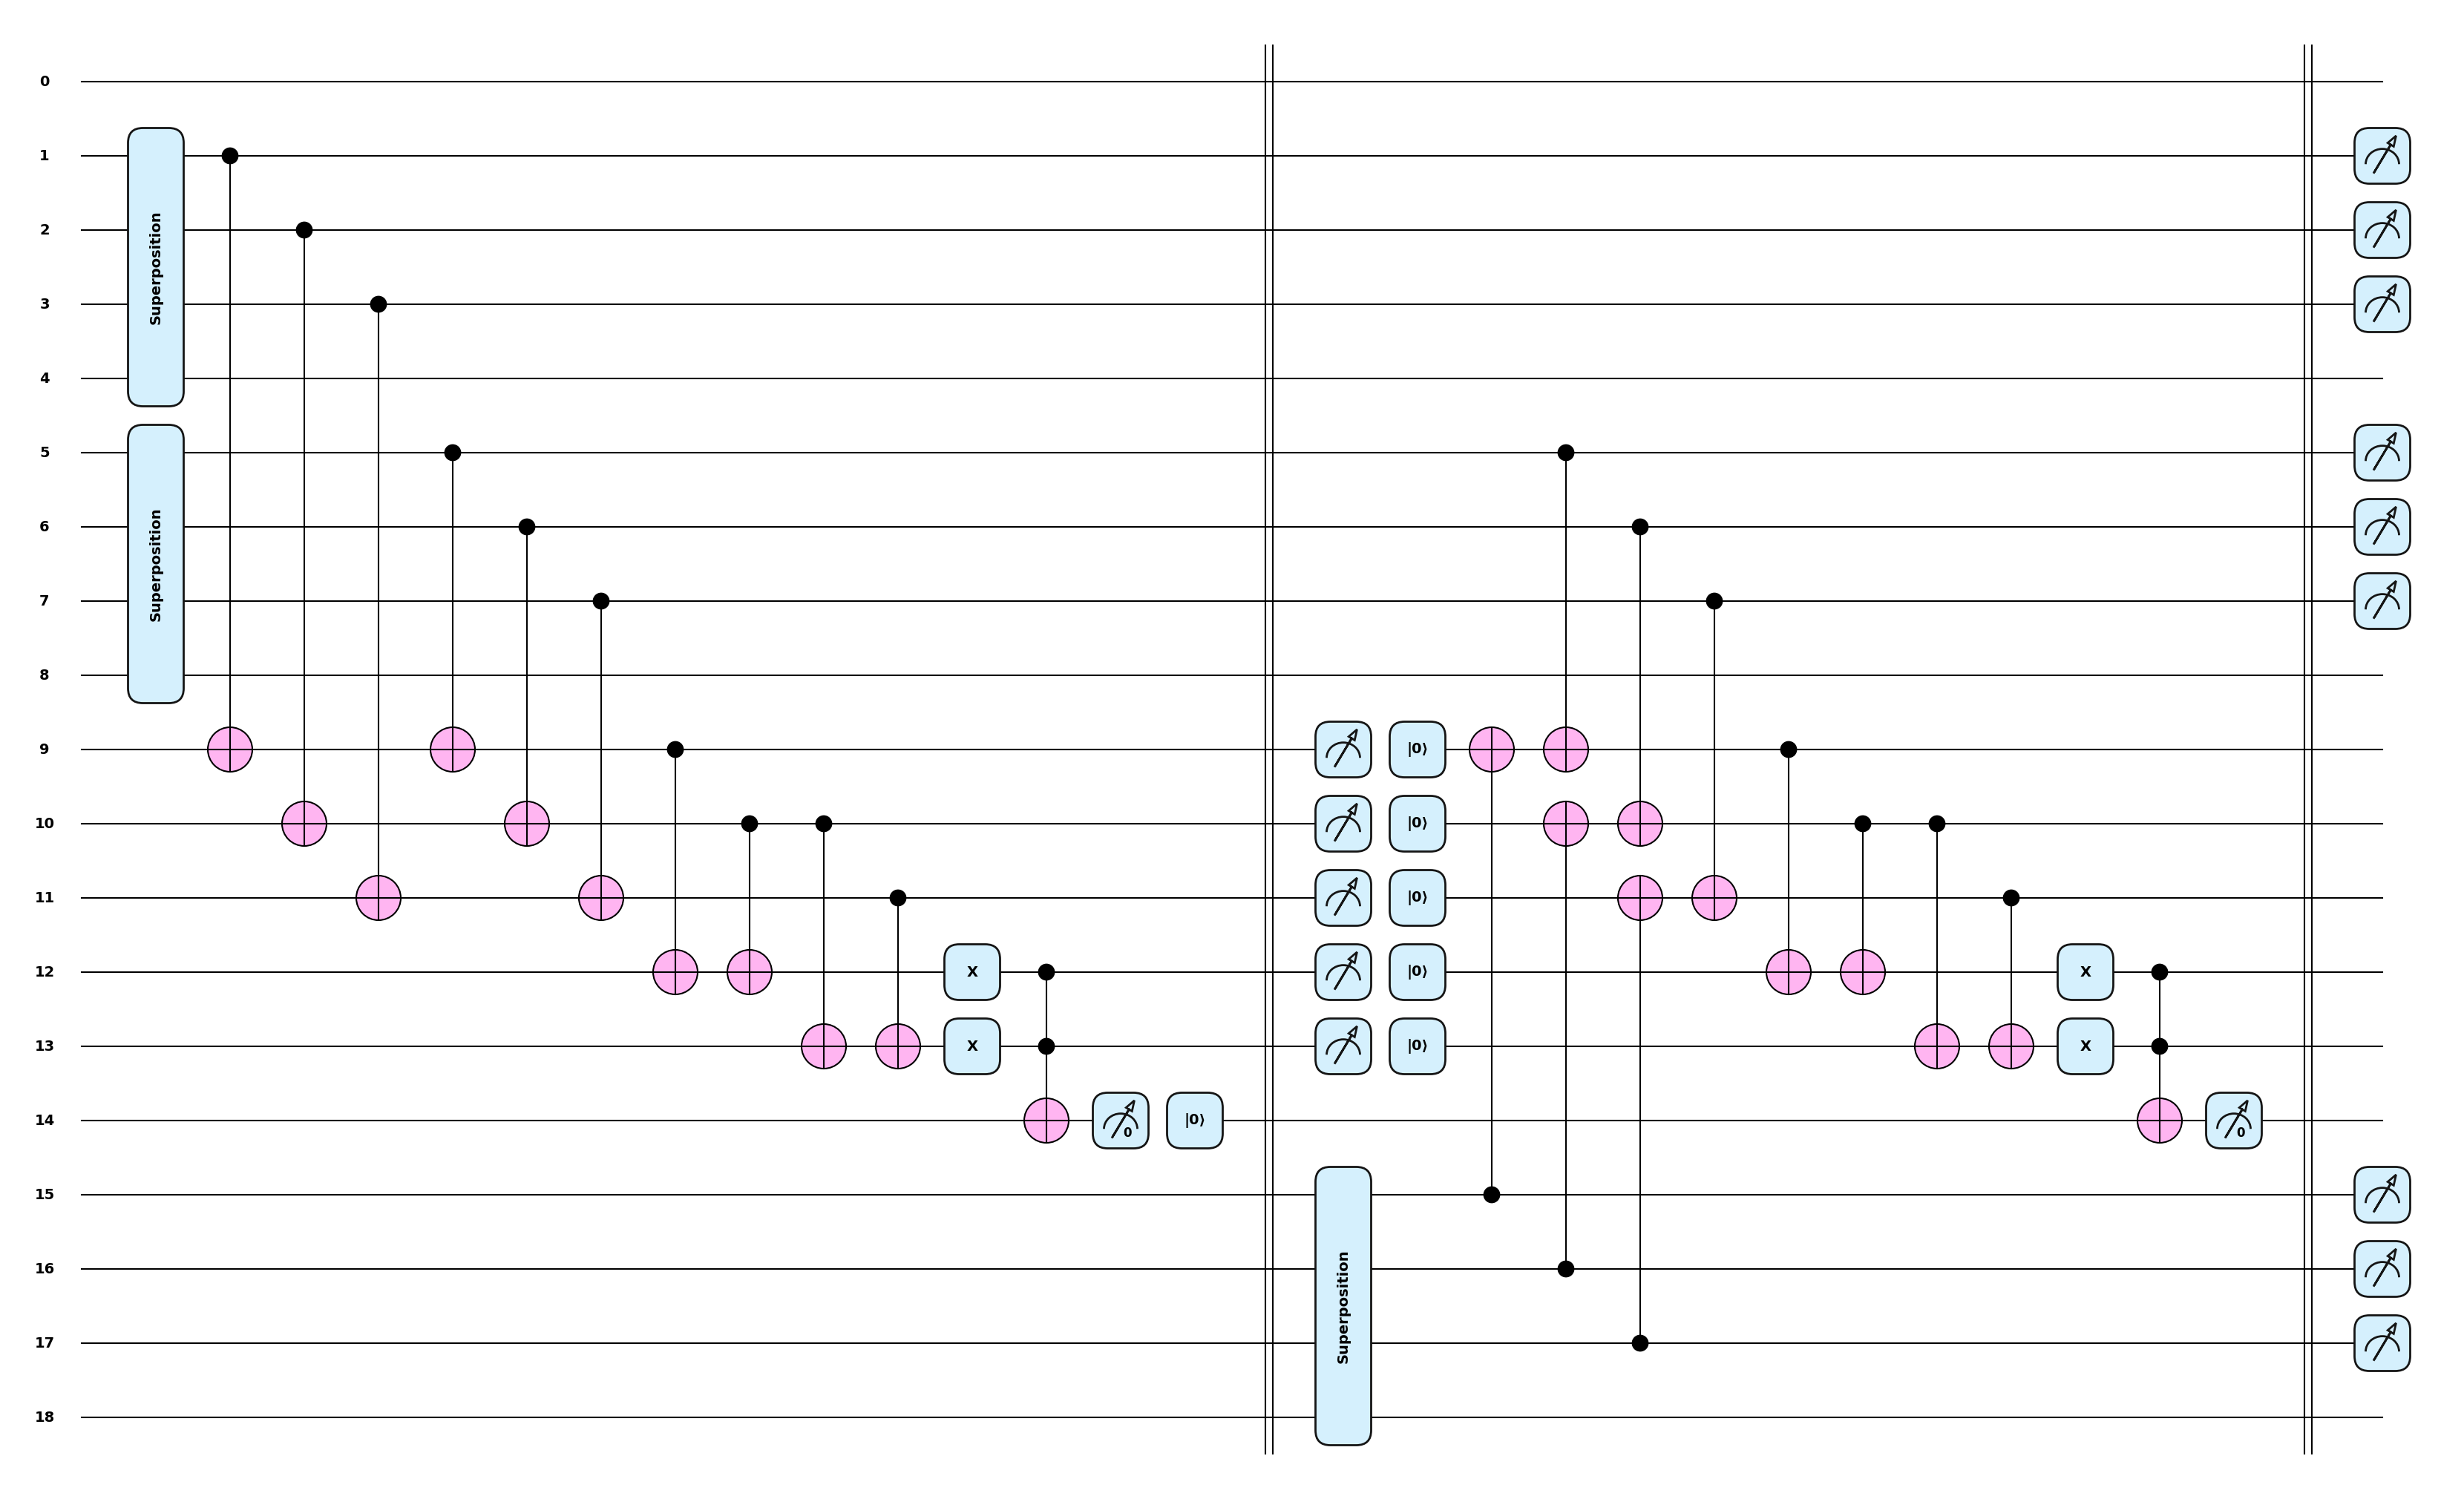

In [44]:
fig, _ = qml.draw_mpl(circuit, style="pennylane", show_all_wires=True)(test_arr)
plt.show()

In [45]:
fig.savefig('logic_result1.png')

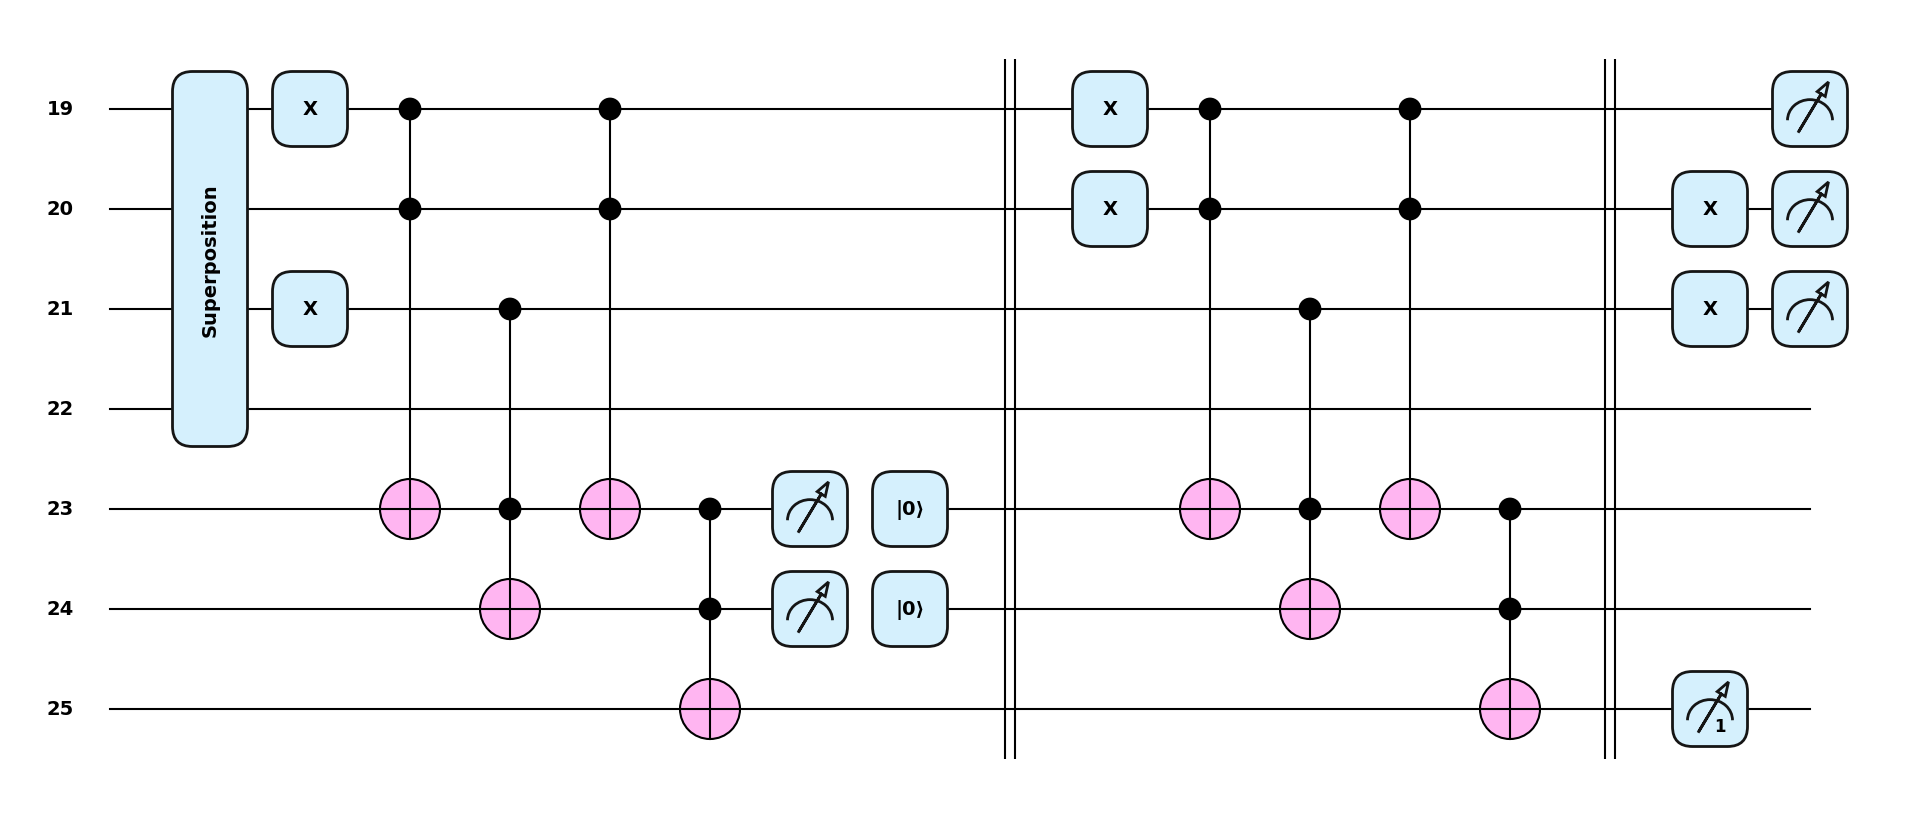

In [135]:
# the density matrix to swap test to discern unique values
dev2 = qml.device('default.qubit', wires=np.arange(19,26,1))

@qml.qnode(dev2)
def circuit():
    # TOT
    arr = [[0,0,0],[0,0,1],[0,1,0],[1,0,0],[0,1,1],[1,0,1],[1,1,0],[1,1,1]]
    coeff = np.sqrt(np.ones(len(arr))/len(arr))
    base = np.array(arr)
    qml.Superposition(coeff, base, wires=[19,20,21], work_wire=22)

    qml.PauliX(19)
    qml.PauliX(21)

    qml.Toffoli([19,20,23])
    qml.Toffoli([21,23,24])
    qml.Toffoli([19,20,23])
    qml.Toffoli([23,24,25])

    qml.measure(23, reset=True)
    qml.measure(24, reset=True)
    qml.Barrier(np.arange(19,26,1))
    
    qml.PauliX(19)
    qml.PauliX(20)

    qml.Toffoli([19,20,23])
    qml.Toffoli([21,23,24])
    qml.Toffoli([19,20,23])
    qml.Toffoli([23,24,25])

    qml.Barrier(np.arange(19,26,1))
    qml.PauliX(20)
    qml.PauliX(21)
    
    qml.measure(25, postselect=1)

    return qml.probs([19,20,21])

fig, _ = qml.draw_mpl(circuit, style="pennylane", show_all_wires=True)()
plt.show()

In [136]:
fig.savefig('logic_result2.png')

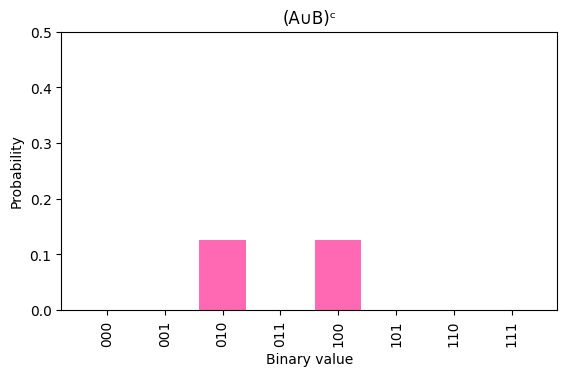

In [134]:
# probability plot
e = 1/8
c = [0,0,e,0,e,0,0,0]
plt.bar(bit_strings, c, color='hotpink')
plt.xlabel("Binary value")
plt.ylabel("Probability")
plt.ylim([0,0.5])
plt.xticks(rotation="vertical")
plt.subplots_adjust(bottom=0.3)
plt.title('(A∪B)ᶜ')
plt.show()